In [1]:
# command allowing notebooks to execute python scripts in project
import sys, os
sys.path.insert(0, os.path.dirname(os.path.abspath(".")))

from fastai import *
from fastai.text import *
from fastai.callbacks import *
import pandas as pd
from pathlib import Path
import json

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score

#from konlpy.tag import Okt
#import jpype

# 1 - Load data

## 1-1 Get wiki data

In [2]:
from multifit.nlputils import split_wiki, get_wiki
from multifit.nlputils2 import clean_files, get_num_tokens, get_corpus

In [6]:
lang = 'ko'
data_path = Path('/home/amaleelhamri/multifit/data/korean')
name = f'{lang}wiki'
path = data_path/name
path.mkdir(exist_ok=True, parents=True)
mdl_path = path/'models'
bs = 256

lm_fns3 = [f'{lang}_wt_sp15_multifit', f'{lang}_wt_vocab_sp15_multifit']
lm_fns3_bwd = [f'{lang}_wt_sp15_multifit_bwd', f'{lang}_wt_vocab_sp15_multifit_bwd']

In [14]:
%%time
get_wiki(path,lang)

downloading...


unzipping...
extracting...
CPU times: user 2min 5s, sys: 4.14 s, total: 2min 9s
Wall time: 7min 47s


In [15]:
%%time
dest = split_wiki(path, lang)

0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
CPU times: user 4.54 s, sys: 1.66 s, total: 6.2 s
Wall time: 6.24 s


In [7]:
dest = path/"docs"

In [10]:
!head -n4 {path}/{name}

<doc id="5" url="https://ko.wikipedia.org/wiki?curid=5" title="지미 카터">
지미 카터

제임스 얼 "지미" 카터 주니어(, 1924년 10월 1일 ~ )는 민주당 출신 미국 39번째 대통령 (1977년 ~ 1981년)이다.


In [11]:
folder = "docs"
clean_files(path, folder)

In [16]:
dest = path/'docs'
dest.ls()[:5]

[PosixPath('/home/amaleelhamri/multifit/data/korean/kowiki/docs/섀도 복사본.txt'),
 PosixPath('/home/amaleelhamri/multifit/data/korean/kowiki/docs/디도 (성경).txt'),
 PosixPath('/home/amaleelhamri/multifit/data/korean/kowiki/docs/개그야.txt'),
 PosixPath('/home/amaleelhamri/multifit/data/korean/kowiki/docs/펠릭스 멘델스존.txt'),
 PosixPath('/home/amaleelhamri/multifit/data/korean/kowiki/docs/듀얼쇼크.txt')]

In [17]:
%%time
num_files, num_tokens = get_num_tokens(dest)
print(f'{num_files} files - {num_tokens} tokens')

29814 files - 29929080 tokens
CPU times: user 4.02 s, sys: 736 ms, total: 4.76 s
Wall time: 4.75 s


In [18]:
%%time
path_corpus = get_corpus(dest, path, num_tokens, obj_tokens=1e8)

As there are less than 100 000 000 tokens in the initial corpus, we use it.
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 97.8 µs


## 1 - 2 Build databunch

In [ ]:
OKT_TOKENIZER_KO = Okt()
def tokenize_korean_text(text):
    """
    Function that tokenizes and normalizes korean texts
    :param str text: text written in korean

    :return: list of korean tokens
    :rtype: list(str)
    """
    if jpype.isJVMStarted():
        jpype.attachThreadToJVM()
    return OKT_TOKENIZER_KO.morphs(str(text))

In [8]:
%%time
data = (TextList.from_folder(dest, processor=[OpenFileProcessor(), SPProcessor(max_vocab_sz=10000, lang='ko')])
        .split_by_rand_pct(0.1, seed=42)
        .label_for_lm()
        .databunch(bs=bs, num_workers=8))

CPU times: user 20min 11s, sys: 6.11 s, total: 20min 17s
Wall time: 5min 55s


In [ ]:
data.save(f'{path}/{lang}_databunch_sp15_multifit')

In [9]:
len(data.vocab.itos), len(data.train_ds)

(10000, 26833)

In [10]:
data.train_ds.x[1]

Text ▁xxbos ▁디 도 ( 공 동 번 역 , ▁개신교 ), ▁티 토 ( 가 톨 릭 ) ( ; ▁ ) 는 ▁초기 ▁기독교 의 ▁선 교 사 이자 ▁교회 ▁지도자 로 , ▁디 도 서 ▁등의 ▁바 울 ▁서 신 에서 ▁언급 되는 ▁사 도 ▁바 울 로 의 ▁동 역 자 이다 . ▁바 울 로 에 ▁의해 ▁기독교 로 ▁개 종 한 ▁것으로 ▁보 이며 , ▁전 승 에 ▁의하면 ▁그는 ▁크레 타 의 ▁감독으로 ▁세워 졌다 고 ▁한다 . ▁디 도 는 ▁코 린 토스 ( 고 린 도 ) ▁교회 에 ▁예 루 살 렘 의 ▁ 가 난 한 ▁성 도 들을 ▁도와 달 라는 ▁편지 를 ▁바 울 로 에게서 ▁받아 ▁전달 한다 . ▁이후에 ▁크레 타 에서 ▁디 도 는 ▁죽 을 때 ▁ 까지 ▁크레 타 섬 의 ▁모든 ▁도시 에 ▁장 로 를 ▁임명 했고 , ▁칸 디아 ( 현재 의 ▁ 이라 클리 오 ) ▁주변 에 ▁있는 ▁도시 인 ▁고 르 티 나 에서 ▁숨 을 ▁거두었다 고 ▁전 해 진다 . ▁디 도 는 ▁헬 라 인 이며 ▁안 티 오 키 아 ▁출신 으로 ▁여겨 지 는데 , ▁젊은 ▁나이 에 ▁그리스 ▁철학 과 ▁시 학 을 ▁배 웠다 고 ▁전 해 진다 . ▁그는 ▁또한 ▁바 울 로 에 ▁의해 ▁회 심 한 것 으로 ▁보 이며 , ▁바 울 로 의 ▁통 역 자 이자 ▁비 서 관으로 ▁활동 했다 . ▁그는 ▁또한 ▁ 49 세에 ▁예 루 살 렘 에서 ▁열린 ▁모 세의 ▁ 율 법 에 ▁대한 ▁공 회 에 ▁바 울 로 , ▁ 바르 나 바 와 ▁함께 ▁동 행 했고 ( 갈 ▁2 : 1 -3 ) . ▁바 울 로 가 ▁비록 ▁유대인 에 ▁대한 ▁사 역 을 ▁위해 ▁디 모 테 오 의 ▁할 례 에 ▁동 의 했지만 , ▁기본적으로 ▁이 방 인 ▁개 종 자에게 ▁할 례 가 ▁필요 하지 ▁않다 는 ▁태도 를 ▁취 했 으므로 ▁디 도 는 ▁할 례 를 ▁받지 ▁않았다 ( 갈 ▁2 : 3 - 5 ) . ▁바 울 로 가 ▁ 56 세 쯤 ▁되어 ▁아시아 에서 ▁떠나 게 ▁ 되었을 ▁때 ▁디 도 를 ▁ 에 페 소 스 에서 ▁코 린 토스 로 ▁보내 

# 2 - Train LM

In [6]:
data = load_data(path, f'{lang}_databunch_sp15_multifit')

In [11]:
config = awd_lstm_lm_config.copy()
config['qrnn'] = True
config['n_hid'] = 1550 #default 1152
config['n_layers'] = 4 #default 3

In [12]:
perplexity = Perplexity()
learn = language_model_learner(data, AWD_LSTM, config=config, drop_mult=1., pretrained=False, 
                               metrics=[error_rate, accuracy, perplexity]).to_fp16()

In [13]:
learn.unfreeze()

In [14]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


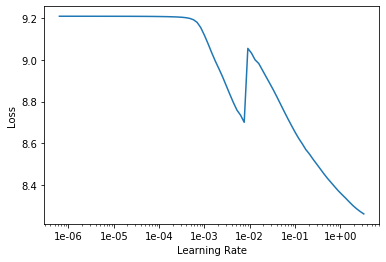

In [15]:
learn.recorder.plot()


In [16]:
lr = 1e-03
lr *= bs/48
wd = 0.01 


epoch,train_loss,valid_loss,error_rate,accuracy,perplexity,time
0,9.210296,9.210295,0.999284,0.000716,9999.543945,26:33
1,9.210299,9.210295,0.999284,0.000716,9999.534180,26:31
2,9.210279,9.210295,0.999284,0.000716,9999.534180,26:36
3,9.210284,9.210295,0.999284,0.000716,9999.534180,26:39
4,9.210316,9.210295,0.999284,0.000716,9999.534180,26:38
5,9.210309,9.210295,0.999284,0.000716,9999.534180,26:38
6,9.210290,9.210295,0.999284,0.000716,9999.534180,26:37
7,9.210315,9.210295,0.999284,0.000716,9999.534180,26:38


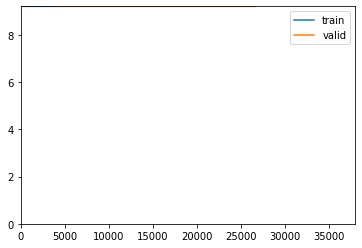

Better model found at epoch 0 with accuracy value: 0.0007163433474488556.


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

In [ ]:
%%time
learn.fit_one_cycle(10, lr, wd=wd, moms=(0.8,0.7), 
                    callbacks=[ShowGraph(learn),
                               SaveModelCallback(learn.to_fp32(),
                                                 monitor='accuracy',
                                                 name='bestmodel_sp15_multifit')])

In [ ]:
mdl_path = path/'models'
mdl_path.mkdir(exist_ok=True)
learn.to_fp32().save(mdl_path/lm_fns3[0], with_opt=False)
learn.data.vocab.save(mdl_path/(lm_fns3[1] + '.pkl'))